<img src = "https://github.com/VeryFatBoy/notebooks/blob/main/common/images/img_github_singlestore-jupyter_featured_2.png?raw=true">

<div id="singlestore-header" style="display: flex; background-color: rgba(235, 249, 245, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/browser.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">Building Predictive Analytics for Loan Approvals</h1>
    </div>
</div>

___
## Install libraries

In [3]:
!pip cache purge

Files removed: 0


In [4]:
!pip install langchain --quiet
!pip install langchain-community --quiet
!pip install langchain-openai --quiet
!pip install lime --quiet
!pip install openai --quiet
!pip install scikit-learn --quiet
!pip install seaborn --quiet
!pip install shap --quiet
!pip install torch --quiet
!pip install transformers --quiet
!pip install wordcloud --quiet

In [5]:
import io
import lime
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import requests
import seaborn as sns
import shap
import warnings

from langchain_community.agent_toolkits.sql.base import create_sql_agent
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain_community.utilities import SQLDatabase
from langchain_openai import ChatOpenAI
from lime.lime_tabular import LimeTabularExplainer
from singlestoredb.management import get_secret
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from transformers import DistilBertTokenizer, DistilBertForMaskedLM, pipeline
from wordcloud import WordCloud

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
logging.basicConfig(level = logging.ERROR)
warnings.filterwarnings("ignore", category = FutureWarning)

___
## Load the data

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Action Required</b></p>
        <p>The CSV data file is hosted on a Google Drive.</p>
        <p>You will be prompted to add several domains to the notebook firewall.</p>
    </div>
</div>

In [6]:
file_id = "1LIvIdqdHDFEGnfzIgEh4L6GFirzsE3US"
url = f"https://drive.google.com/uc?id={file_id}"

# Download the contents of the CSV file
download = requests.get(url).content

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(io.StringIO(download.decode("utf-8")))

In [7]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [8]:
df.count()

Loan_ID              598
Gender               598
Married              598
Dependents           586
Education            598
Self_Employed        598
ApplicantIncome      598
CoapplicantIncome    598
LoanAmount           577
Loan_Amount_Term     584
Credit_History       549
Property_Area        598
Loan_Status          598
dtype: int64

___
## Data preprocessing

In [9]:
# Drop incomplete rows
df.dropna(inplace = True)

In [10]:
df.count()

Loan_ID              505
Gender               505
Married              505
Dependents           505
Education            505
Self_Employed        505
ApplicantIncome      505
CoapplicantIncome    505
LoanAmount           505
Loan_Amount_Term     505
Credit_History       505
Property_Area        505
Loan_Status          505
dtype: int64

In [11]:
# Exclude the Loan_ID column
df.drop(columns = ["Loan_ID"], inplace = True)

In [12]:
# Separate features and target variable
X = df.drop("Loan_Status", axis = 1)
y = df["Loan_Status"]

___
## Visualisation

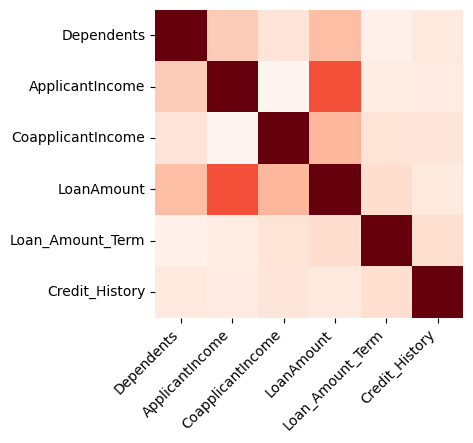

In [13]:
# Create the heatmap
plt.figure(figsize = (4, 4))

ax = sns.heatmap(
    X.corr(numeric_only = True),
    cmap = "Reds",
    square = True,
    cbar = False
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = "right"
)

plt.show()

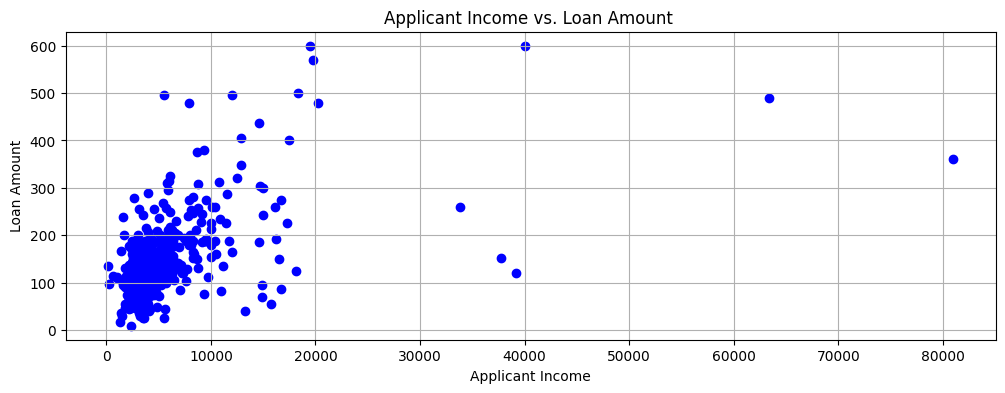

In [14]:
# Create the scatter plot
plt.figure(figsize = (12, 4))
plt.title("Applicant Income vs. Loan Amount ")

plt.grid()
plt.scatter(X["ApplicantIncome"], X["LoanAmount"], c = "b")
plt.xlabel("Applicant Income")
plt.ylabel("Loan Amount")

plt.show()

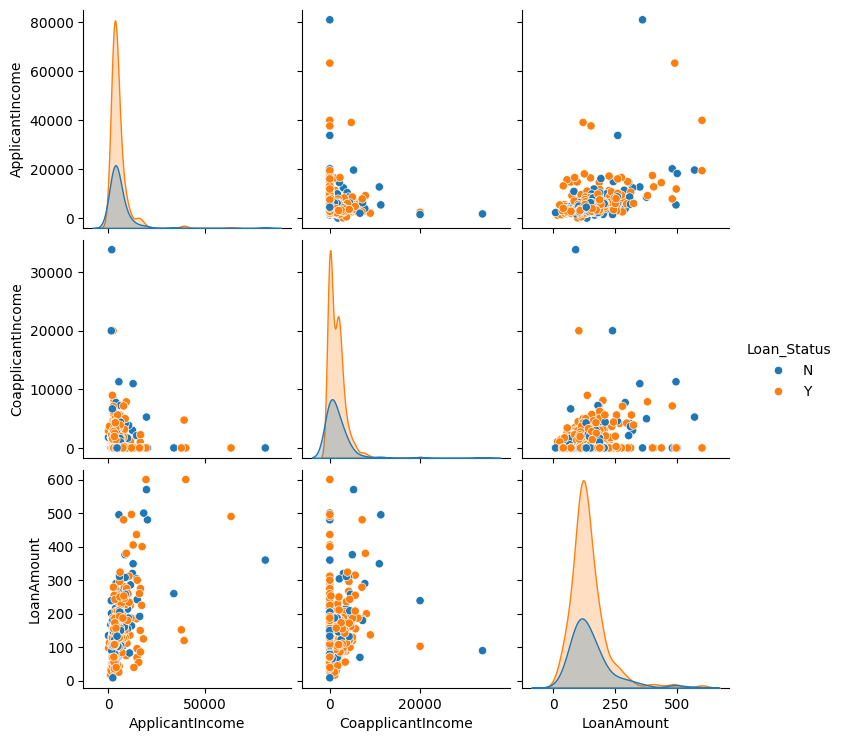

In [15]:
# Select only the numerical features
numerical_features = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]

# Combine the target variable with the selected numerical features
data_to_plot = pd.concat([X[numerical_features], y], axis = 1)

# Create the pair plot
sns.pairplot(data_to_plot, hue = "Loan_Status", diag_kind = "kde")

___
## Feature engineering

In [16]:
# Identify categorical columns
categorical_cols = [
    "Gender",
    "Married",
    "Dependents",
    "Education",
    "Self_Employed",
    "Property_Area"
]

# Apply label encoding to binary categorical variables
label_encoder = LabelEncoder()
for col in categorical_cols:
    # Check if the column is binary
    if len(X[col].unique()) == 2:
        X[col] = label_encoder.fit_transform(X[col])

# Apply one-hot encoding to multi-category categorical variables
X = pd.get_dummies(X, columns=["Dependents", "Property_Area"], drop_first = False)

___
## Logistic Regression for loan approval

### Model training

In [17]:
SEED = 42

In [18]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = SEED
)

In [19]:
# Initialise and train a logistic regression model
model = LogisticRegression(max_iter = 10000, random_state = SEED)
model.fit(X_train.values, y_train)

LogisticRegression(max_iter=10000, random_state=42)

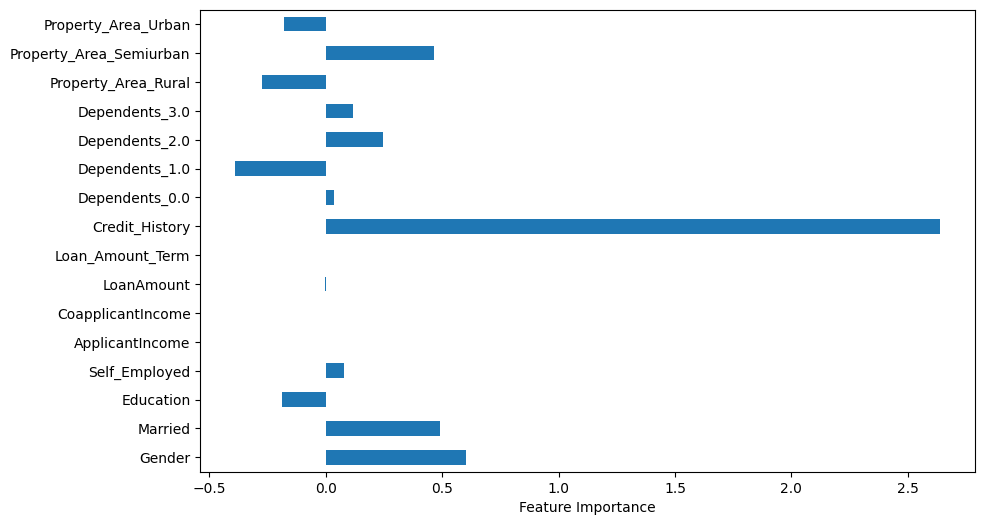

In [20]:
# Visualise feature importance
feature_importances = pd.Series(model.coef_[0], index = X_train.columns)
feature_importances.plot(kind = "barh", figsize = (10, 6))

plt.xlabel('Feature Importance')

plt.show()

In [21]:
# Make predictions on the test set
y_pred = model.predict(X_test.values)

In [22]:
# Choose a test sample for generating a loan application summary
# 0 is the first row in the DataFrame
sample_index = 0
sample_features = X_test.iloc[sample_index]
sample_features = sample_features.replace({True: 1, False: 0})

In [23]:
sample_features

Gender                        1.0
Married                       1.0
Education                     0.0
Self_Employed                 1.0
ApplicantIncome            7787.0
CoapplicantIncome             0.0
LoanAmount                  240.0
Loan_Amount_Term            360.0
Credit_History                1.0
Dependents_0.0                0.0
Dependents_1.0                1.0
Dependents_2.0                0.0
Dependents_3.0                0.0
Property_Area_Rural           0.0
Property_Area_Semiurban       0.0
Property_Area_Urban           1.0
Name: 207, dtype: float64

In [24]:
# Initialise the property area value
property_area_value = "Unknown"

# Iterate through columns in sample_features
for col, value in sample_features.items():
    if col.startswith("Property_Area_") and value == 1.0:
        property_area_value = col.replace("Property_Area_", "")
        break

### BERT text generation

[BERT (Bidirectional Encoder Representations from Transformers)](https://github.com/google-research/bert), is a Natural Language Processing (NLP) model developed by Google. It's built upon the Transformer architecture and represents a significant advancement in understanding and processing human language.

BERT differs from earlier NLP models in that it takes into account the context of a word by looking at the words before and after it in a sentence, which is known as bidirectional contextual learning. This bidirectional approach enables BERT to capture complex linguistic relationships and semantics in a text more effectively.

BERT is pretrained on massive quantities of text data, and the resulting model can be fine-tuned for various NLP tasks, such as text classification, question answering, and language translation, making it highly adaptable and widely used in a variety of natural language understanding tasks in the field of machine learning and AI.

In [25]:
# Initialise the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
bert_model = DistilBertForMaskedLM.from_pretrained("distilbert-base-uncased")

# Define a text generation pipeline
text_generator = pipeline(
    "fill-mask",
    model = bert_model,
    tokenizer = tokenizer
)

#### Simple BERT example

In [26]:
# Fill in the mask in the input text
input_text = "The quick brown [MASK] jumped over the lazy dog."
filled_in_text = text_generator(input_text)

print(filled_in_text[0]["sequence"])

the quick brown dog jumped over the lazy dog.


#### BERT for loan application

In [27]:
# Generate a loan application summary using BERT
input_text = f"""
    Applicant: Mr Blobby
    Income: ${sample_features['ApplicantIncome']}
    Credit History: {sample_features['Credit_History']}
    Loan Amount: ${sample_features['LoanAmount']}
    Property Area: {property_area_value} [MASK]
"""
bert_generated_text = text_generator(input_text)

# Combine model predictions and BERT-generated text for loan approval decision
if y_pred[sample_index] == "Y":
    loan_approval_decision = "Approved"
else:
    loan_approval_decision = "Denied"

In [28]:
# Print the loan application summary, model prediction, and approval decision
print("BERT-Generated Loan Application Summary\n")
print(bert_generated_text[0]["sequence"])
print("\nModel Prediction ('Y' = Approved, 'N' = Denied):", y_pred[sample_index])
print("Loan Approval Decision:", loan_approval_decision)

BERT-Generated Loan Application Summary

applicant : mr blobby income : $ 7787. 0 credit history : 1. 0 loan amount : $ 240. 0 property area : urban area

Model Prediction ('Y' = Approved, 'N' = Denied): Y
Loan Approval Decision: Approved


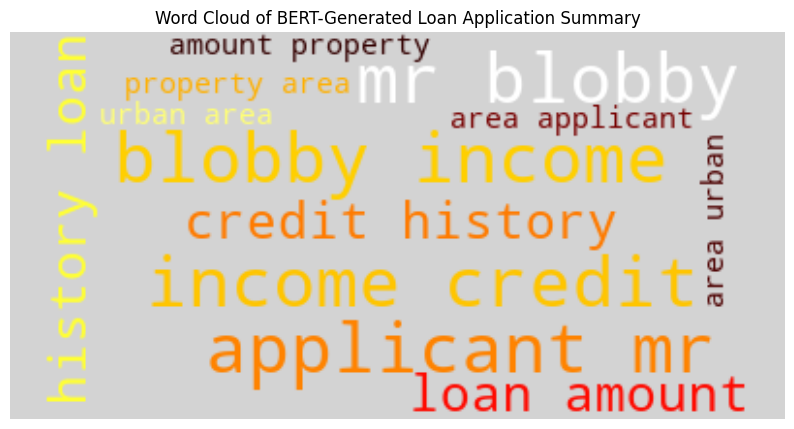

In [29]:
# Get the BERT-generated loan application summary
bert_generated_summary = []
for i in range(len(X_test)):
    bert_generated_summary.append(
        text_generator(input_text)[0]["sequence"]
    )

# Create a word cloud from the BERT-generated summary
wordcloud = WordCloud(
    background_color = "lightgrey",
    colormap = "hot",
    max_font_size = 36
).generate(" ".join(bert_generated_summary))

# Plot the word cloud
plt.figure(figsize = (10, 8))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.title("Word Cloud of BERT-Generated Loan Application Summary")
plt.show()

### SHAP explanations

[SHAP (SHapley Additive exPlanations)](https://github.com/shap/shap) is a sophisticated tool rooted in cooperative game theory that provides a systematic approach to explaining the output of machine learning models. It enables data scientists and machine learning practitioners to dissect the black-box nature of these models by quantifying the contribution of each input feature to individual predictions.

SHAP can be applied across various model types, offering insights into feature importance, directionality of impact (positive or negative), and overall model behavior. It does so through visualizations like summary plots, feature importance plots, and instance-level explanations, making it a valuable asset for model interpretation, debugging, and guiding feature engineering decisions in technical contexts where understanding model decision-making is paramount.

In [30]:
# Explain model predictions using SHAP
explainer = shap.Explainer(model, X_train)
shap_values = explainer.shap_values(X_test)

# Create a DataFrame to store SHAP values and feature names
shap_df = pd.DataFrame({"Feature": X.columns, "SHAP Value": shap_values[0]})

# Sort the DataFrame by absolute SHAP values (for importance ranking)
shap_df["Absolute SHAP"] = abs(shap_df["SHAP Value"])
shap_df = shap_df.sort_values(by = "Absolute SHAP", ascending = False).drop(columns = ["Absolute SHAP"])

# Display the top N features
N = 10
top_features = shap_df.head(N)

# Print the top features and their SHAP values
print(top_features.to_string(index = False))

                Feature SHAP Value
         Dependents_1.0  -0.337879
             LoanAmount  -0.317435
         Credit_History    0.31661
Property_Area_Semiurban  -0.212762
                Married   0.191308
                 Gender   0.150551
    Property_Area_Urban  -0.131527
      CoapplicantIncome   0.116559
        ApplicantIncome   0.078567
    Property_Area_Rural   0.074051


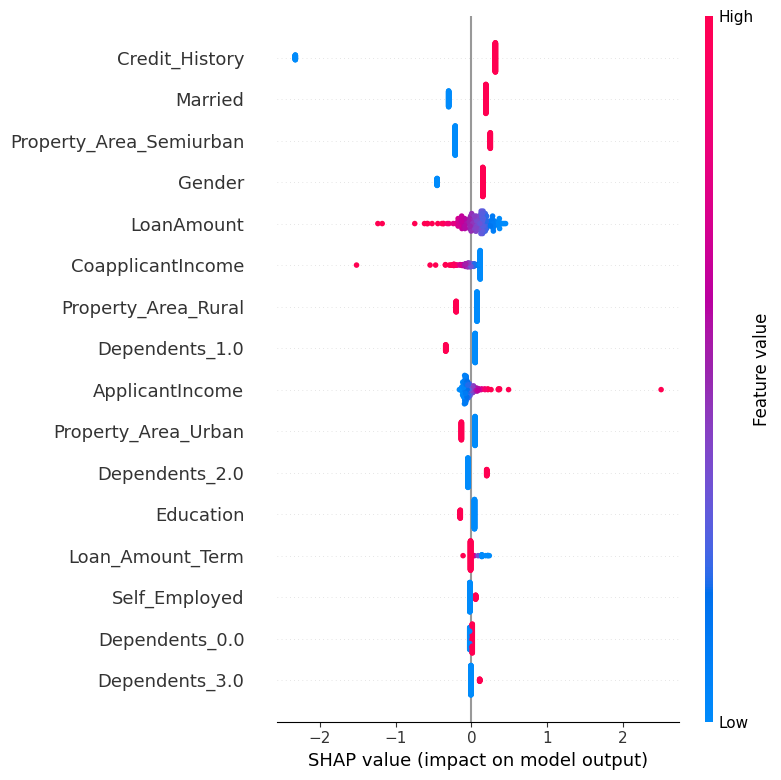

In [31]:
# Cast the SHAP values to float32
shap_values = shap_values.astype("float32")

# Plot the summary plot
shap.summary_plot(shap_values, X_test)

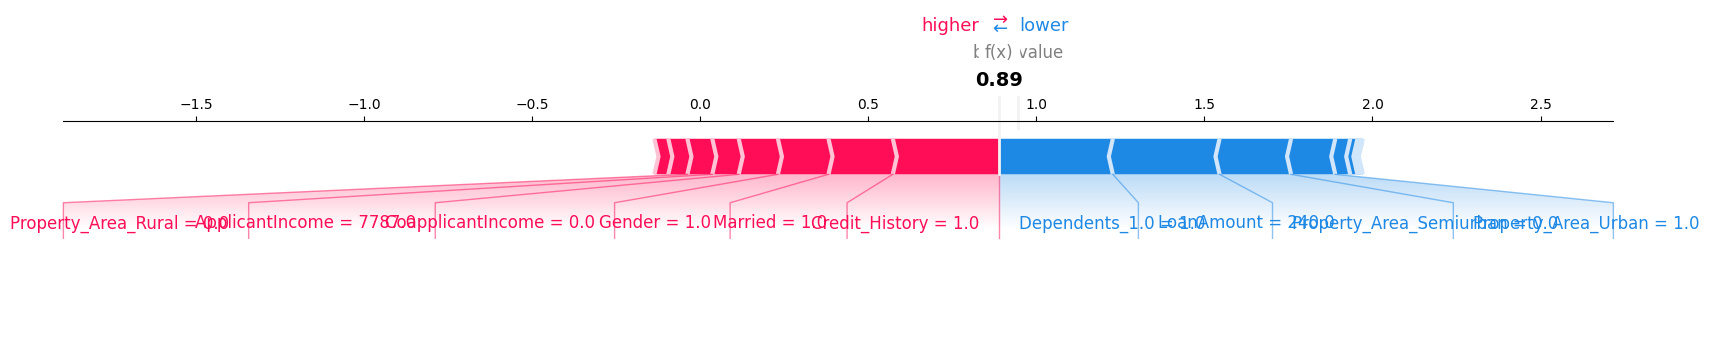

<Figure size 1000x1000 with 0 Axes>

In [32]:
# Create the force plot
shap.initjs()

shap.force_plot(
    explainer.expected_value,   # The expected value of the model
    shap_values[sample_index],  # SHAP values for the chosen prediction
    X_test.iloc[sample_index],  # Features for the chosen prediction
    feature_names = X.columns,  # List of feature names
    matplotlib = True
)

# Control the size of the figure using Matplotlib parameters
plt.gcf().set_size_inches(10, 10)

plt.rcParams.update({"font.size": 18})

plt.show()

### LIME explanations

[LIME (Local Interpretable Model-Agnostic Explanations)](https://github.com/marcotcr/lime) is a machine learning technique designed to provide understandable explanations for individual predictions made by complex models, even when those models are difficult to interpret (often called "black-box" models). 

It works by selecting a specific data instance, making slight modifications to its features, and training a simple, interpretable model on this perturbed data. This interpretable model, called a "local surrogate," approximates the behaviour of the complex model for that specific instance, allowing users to gain insights into why the model made a particular prediction. 

These insights are presented in a human-readable format, making it easier for users to understand the decision-making process of the machine learning model for that specific case. LIME is a valuable tool for improving model transparency and trustworthiness in various domains, enhancing our ability to interpret and trust the predictions made by AI systems.

In [33]:
# Get the feature names that were used during model training
feature_names = X_train.columns.tolist()

# Create a LIME explainer with feature names
explainer = LimeTabularExplainer(
    X_train.values,
    mode = "classification",
    feature_names = feature_names
)

# Choose a specific prediction instance to explain
prediction_index = 0
prediction_instance = X_test.values[prediction_index]

# Explain the prediction
explanation = explainer.explain_instance(prediction_instance, model.predict_proba)

# Visualise the explanation
explanation.show_in_notebook(show_table = True)

___
## Evaluation metrics

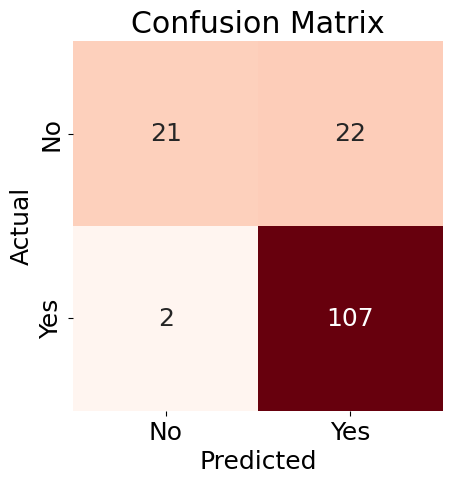

In [34]:
classes = ["No", "Yes"]

sns.heatmap(
    confusion_matrix(y_test, y_pred),
    cmap = "Reds",
    xticklabels = classes,
    yticklabels = classes,
    annot = True,
    cbar = False,
    square = True,
    fmt = ".0f"
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()

In [35]:
print("Confusion Matrix")

pd.crosstab(
    y_test,
    y_pred,
    rownames = ["Actual"],
    colnames = ["Predicted"],
    margins = True
)

Confusion Matrix


Predicted,N,Y,All
Actual,,,
N,21,22,43
Y,2,107,109
All,23,129,152


In [36]:
# Compute model predictions
y_pred = model.predict(X_test.values)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label = "Y")
recall = recall_score(y_test, y_pred, pos_label = "Y")
f1 = f1_score(y_test, y_pred, pos_label = "Y")

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

# Generate a classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Accuracy: 0.84
Precision: 0.83
Recall: 0.98
F1-score: 0.90
Classification Report:
              precision    recall  f1-score   support

           N       0.91      0.49      0.64        43
           Y       0.83      0.98      0.90       109

    accuracy                           0.84       152
   macro avg       0.87      0.74      0.77       152
weighted avg       0.85      0.84      0.82       152



___
## LangChain for loan approval

### Create the database

In [37]:
shared_tier_check = %sql SHOW VARIABLES LIKE "is_shared_tier"
if not shared_tier_check or shared_tier_check[0][1] == "OFF":
    %sql DROP DATABASE IF EXISTS loans_db;
    %sql CREATE DATABASE IF NOT EXISTS loans_db;

1 rows affected.

<div class="alert alert-block alert-warning">
    <b class="fa fa-solid fa-exclamation-circle"></b>
    <div>
        <p><b>Action Required</b></p>
        <p>Select the database from the drop-down menu at the top of this notebook. It updates the <b>connection_url</b> which is used by SQLAlchemy to make connections to the selected database.</p>
    </div>
</div>

In [38]:
from sqlalchemy import *

db_connection = create_engine(connection_url)

### Write the DataFrames to SingleStore

In [39]:
# Write the DataFrame to SingleStore
(X_train.join(y_train)).to_sql(
    "loans_train",
    con = db_connection,
    if_exists = "append",
    index = False,
    chunksize = 1000
)

353

In [40]:
# Write the DataFrame to SingleStore
(X_test.join(y_test)).to_sql(
    "loans_test",
    con = db_connection,
    if_exists = "append",
    index = False,
    chunksize = 1000
)

152

___
## LangChain SQL agent

In [41]:
os.environ["OPENAI_API_KEY"] = get_secret("OPENAI_API_KEY")

In [42]:
db = SQLDatabase.from_uri(connection_url, include_tables = ["loans_train"])

llm = ChatOpenAI(model = "gpt-4o-mini", temperature = 0, verbose = False)

toolkit = SQLDatabaseToolkit(db = db, llm = llm)

agent_executor = create_sql_agent(
    llm = llm,
    toolkit = toolkit,
    max_iterations = 15,
    max_execution_time = 60,
    top_k = 3,
    verbose = False
)

## Example queries in English

In [43]:
error_string = "Could not parse LLM output:"

def run_agent_query(query, agent_executor, error_string):
    try:
        result = agent_executor.invoke(query, return_only_outputs = True)["output"]
    except Exception as e:
        error_message = str(e)
        # Check if the error message contains the specific string
        if error_string in error_message:
            # Extract the part after the specific string and strip backticks
            result = error_message.split(error_string)[1].strip().strip('`')
        else:
            result = f"Error occurred: {error_message}"
    return result

In [44]:
query1 = (
"""
    Build a loan approval model.
    Limit your access to 10 rows of the table.
    Use your model to determine if the following loan would be approved:
    Gender: Male
    ApplicantIncome: 7787.0
    Credit_History: 1
    LoanAmount: 240.0
    Property_Area_Urban: 1
    Limit your reply to either 'Approved' or 'Denied'.
"""
)

result1 = run_agent_query(query1, agent_executor, error_string)
print(result1)

Denied


In [45]:
query2 = (
"""
    Build a loan approval model.
    Limit your access to 10 rows of the table.
    Use your model to determine if the following loan would be approved:
    Gender: Female
    ApplicantIncome: 5000.0
    Credit_History: 0
    LoanAmount: 103.0
    Property_Area_Semiurban: 1
    Limit your reply to either 'Approved' or 'Denied'.
"""
)

result2 = run_agent_query(query2, agent_executor, error_string)
print(result2)

Denied


___
## Cleanup

In [46]:
%%sql
DROP TABLE IF EXISTS loans_test;
DROP TABLE IF EXISTS loans_train;

++
||
++
++

In [47]:
shared_tier_check = %sql SHOW VARIABLES LIKE "is_shared_tier"
if not shared_tier_check or shared_tier_check[0][1] == "OFF":
    %sql DROP DATABASE IF EXISTS loans_db;

1 rows affected.